In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import talib as ta
except:
    ta = None

try:
    import pynance as pn
except:
    pn = None

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("viridis")


In [17]:
stock_data_dir = "../data/"
symbols = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']

dfs = {}
required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

for sym in symbols:
    fp = os.path.join(stock_data_dir, f"{sym}.csv")
    if not os.path.exists(fp):
        continue
    
    df = pd.read_csv(fp)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index("Date", inplace=True)
    df = df.sort_index()

    if not all(c in df.columns for c in required_cols):
        continue
    
    df[required_cols] = df[required_cols].apply(pd.to_numeric, errors='coerce')
    df = df.ffill().bfill().dropna()

    dfs[sym] = df


In [24]:
for sym, df in dfs.items():
    if ta is None:
        continue  # Skip if TA-Lib unavailable

    df["SMA_20"] = ta.SMA(df["Close"], timeperiod=20)
    df["SMA_50"] = ta.SMA(df["Close"], timeperiod=50)
    df["RSI_14"] = ta.RSI(df["Close"], timeperiod=14)

    macd, signal, hist = ta.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    df["MACD"] = macd
    df["MACD_signal"] = signal
    df["MACD_hist"] = hist


In [26]:
metrics = {}

for sym, df in dfs.items():
    close = df["Close"]

    # Daily returns
    daily_returns = close.pct_change().dropna()

    # Annualized Sharpe ratio
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

    # Max drawdown
    cumulative = (1 + daily_returns).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1
    max_drawdown = drawdown.min()

    metrics[sym] = {
        "daily_returns": daily_returns,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown
    }


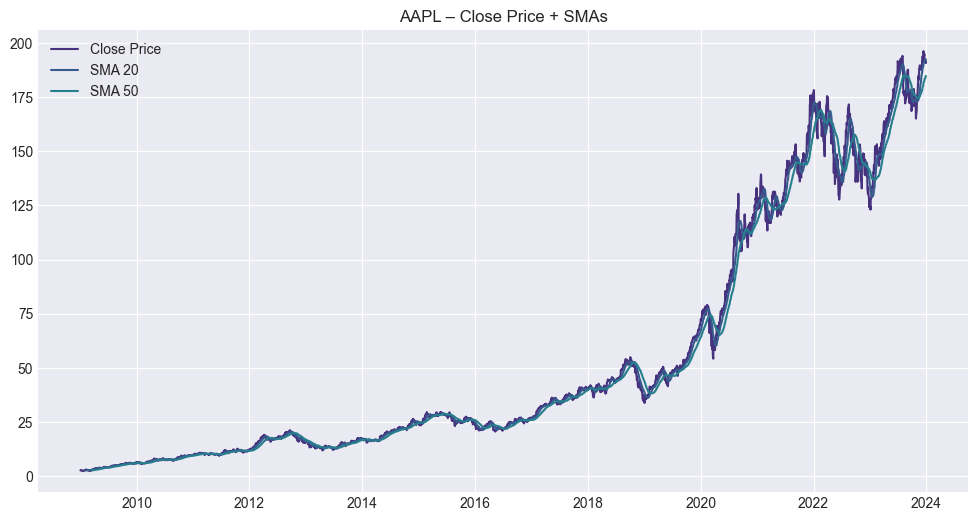

In [27]:
sym = "AAPL"  # Choose any symbol

df = dfs[sym]

plt.figure(figsize=(12,6))
plt.plot(df["Close"], label="Close Price")
if "SMA_20" in df:
    plt.plot(df["SMA_20"], label="SMA 20")
if "SMA_50" in df:
    plt.plot(df["SMA_50"], label="SMA 50")

plt.title(f"{sym} – Close Price + SMAs")
plt.legend()
plt.show()


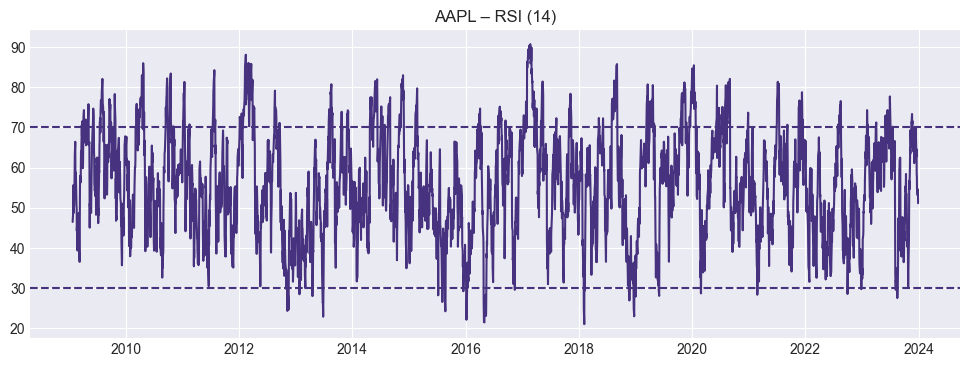

In [28]:
if "RSI_14" in df:
    plt.figure(figsize=(12,4))
    plt.plot(df["RSI_14"])
    plt.axhline(70, linestyle='--')
    plt.axhline(30, linestyle='--')
    plt.title(f"{sym} – RSI (14)")
    plt.show()


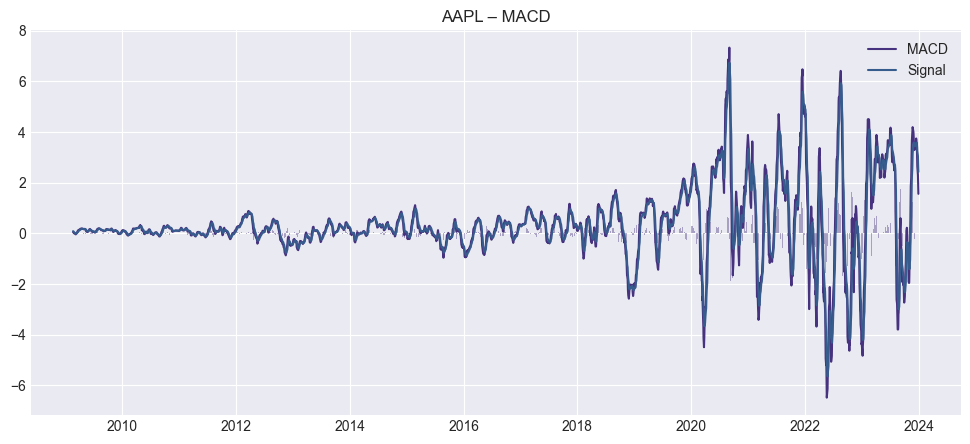

In [29]:
if "MACD" in df:
    plt.figure(figsize=(12,5))
    plt.plot(df["MACD"], label="MACD")
    plt.plot(df["MACD_signal"], label="Signal")
    plt.bar(df.index, df["MACD_hist"], alpha=0.4)
    plt.title(f"{sym} – MACD")
    plt.legend()
    plt.show()


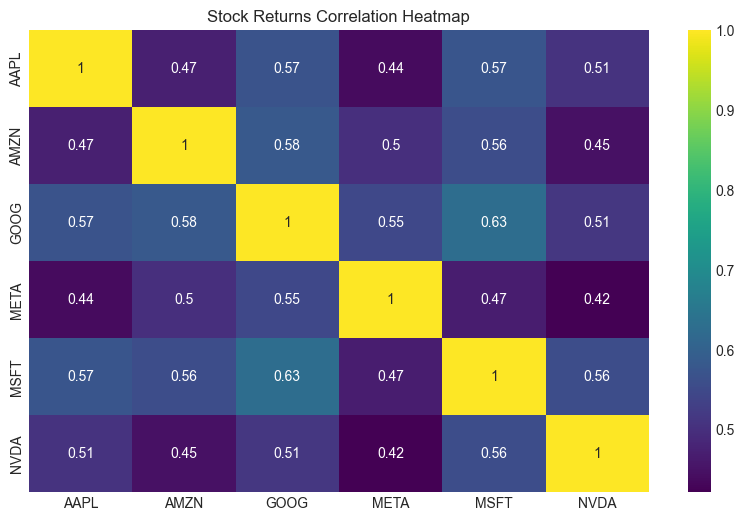

In [30]:
close_prices = pd.DataFrame({sym: dfs[sym]["Close"] for sym in dfs})

plt.figure(figsize=(10,6))
sns.heatmap(close_prices.pct_change().corr(), annot=True, cmap="viridis")
plt.title("Stock Returns Correlation Heatmap")
plt.show()
